# ParSNIP Limitation Analysis
This notebook uses a set of scripts to analyze how the accuracy of ParSNIP's classifications degrade with particular modifications. Our goal is to find which conditions and parameters are most important to producing an accurate classification, and to learn how early in an object's variability a classification can be trusted.

### Current Features
1. Modifies datasets by limiting the maximum number of observations.
2. Modifies datasets by adding an offset to the reference time.
3. Visualizes how classification accuracy changes with modifications.
4. Interactively visualizes how light curve prediction changes with modifications.

### Planned Improvements
1. Currently, cutoff modifications remove observations from the entire curve. Ideally, it would remove fewer points but only from areas of variability. This way we can see which parts of the variability in a class are most important to observe.
2. Add ability to see classification grids for different sets of allowed bandpasses. This will allow us to see which bands are most important to distinguishing classes.

### Important Notes
1. If running this on epyc, I recommend using the kernel called "John Delker's Python 3.10".
2. This notebook can be used with some non-plasticc datasets such as PS1, but a few settings will need to be changed, such as the names of bandpasses. I recommend making sure it runs with plasticc before trying to change the dataset used.

*written by John Delker (jfla@uw.edu) at the University of Washington, Astronomy Department*

## Load dependencies

In [1]:
import modifications as mods
import numpy as np
import analysis
import parsnip
import os

# This forces the local modules to reload when a cell is run. 
# Otherwise, we'd have to restart the kernel if changes are made to a module.
# Will be removed if this notebook is made more publicly available in the future
%load_ext autoreload
%autoreload 2

## Settings

In [2]:
# Paths to the public data folder, along with the desired dataset and predictions
parsnip_data_path = "/epyc/data/parsnip_tests/"
predictions_path = "predictions/parsnip_predictions_plasticc_train_aug_100.h5"
classifier_path = "classifiers/plasticc_classifier"
dataset_path = "data/plasticc_test_slim.h5" # plasticc_test_slim is the first 5000 entries of the full platicc dataset.

# Should a new classifier be loaded from a file, created and saved to a file, or just created temporarily?
classifier_action = "LOAD" # Options: LOAD, CREATE, TEMP

# Information about the dataset
dataset_type = "plasticc" # Options: plasticc, ps1 (untested)
dataset_bands = ["lsstu", "lsstg", "lsstr", "lssti", "lsstz", "lssty"]

# Visual settings
band_colors = ["blue", "green", "red", "purple", "brown", "black"]

# Classes that ParSNIP is currently capable of classifying
parsnip_classes = list(["SNIa", "SNII", "SLSN-I", "SNIa-91bg", "SNIax", "SNIbc", "TDE"])

## Initial Setup

In [3]:
# Loads the dataset, removing any objects that ParSNIP is incapable of classifying
dataset = parsnip.load_dataset(os.path.join(parsnip_data_path, dataset_path))
dataset = dataset[(np.in1d(dataset.meta['type'], parsnip_classes))]
    
# Either loads an existing classifier, creates a new one and saves it, or creates a temporary classifier
if classifier_action == "LOAD":
    classifier = parsnip.Classifier().load(os.path.join(parsnip_data_path, classifier_path))
elif classifier_action == "CREATE":
    classifier = modifications.prepare_classifier(
        os.path.join(parsnip_data_path, predictions_path), 
        os.path.join(parsnip_data_path, classifier_path))
elif classifier_action == "TEMP":
    classifier = modifications.prepare_classifier(os.path.join(parsnip_data_path, predictions_path))

# Store settings in a way that's easy to pass into functions
settings = {
    "model": parsnip.load_model(dataset_type),
    "dataset": dataset,
    "classifier": classifier,
    "all_bands": dataset_bands,
    "band_colors": band_colors
}

Parsing 'plasticc_test_slim.h5' as PLAsTiCC dataset...
Rejecting 0 non-supernova-like light curves.
Dataset contains 5000 light curves.


## Analyzing the predicted light curve changes with modifications

In [12]:
analysis.plot_interactable_curve(settings)

Output()

## Classifying the dataset with various offsets to the reference time

In [4]:
timing_tests = mods.classify_offsets(settings, 5000, settings["all_bands"], [-30, -20, -10, 10, 20, 30])

Preprocessing dataset: 100%|██████████| 4966/4966 [00:18<00:00, 263.27it/s]


## Classifying the dataset with a decreasing limit on observation count

In [5]:
cutoff_tests = mods.classify_cutoffs(settings, 5000, settings["all_bands"], [48, 32, 24, 16, 12, 8])

Preprocessing dataset: 100%|██████████| 4966/4966 [00:11<00:00, 449.33it/s]


## Comparing SNIa vs SNII classifications
ParSNIP often misclassifies Type Ia supernovae as Type II or has a similar probability for each class. The reverse is not true, as it rarely, if ever, classifies a Type II supernova as a Type Ia. Reference time modifications only seem to make misclassifications more likely for SNIa objects, especially when the reference time is shifted backwards. These changes have no effect on SNIa misclassifications for SNII objects, however.

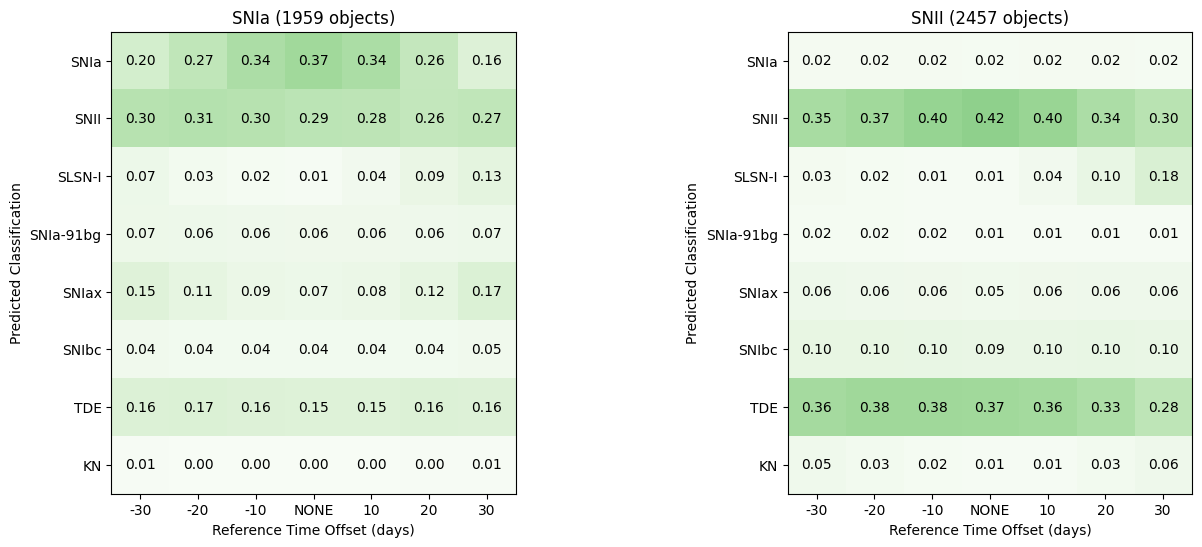

In [13]:
analysis.plot_class_grid(timing_tests, xaxis_label = "Reference Time Offset (days)", classes = "SNIa,SNII", max_objects = -1)

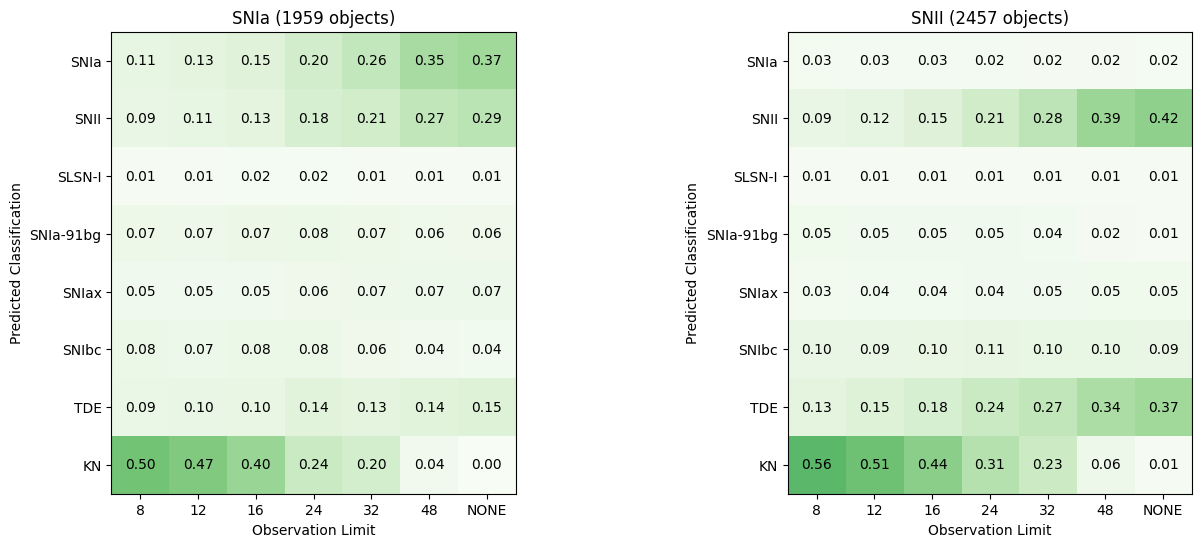

In [14]:
analysis.plot_class_grid(cutoff_tests, xaxis_label = "Observation Limit", classes = "SNIa,SNII", max_objects = -1)

## Comparing SNII vs TDE classifications
SNII are often misclassified as Tidal Disruption Events, while the reverse is not true. However, there are very few TDE in the analyzed dataset, so the accuracy of the TDE results is likely low. When modifying the reference time for SNII objects, the SNII and TDE probabilities seem to follow a similar pattern of change.

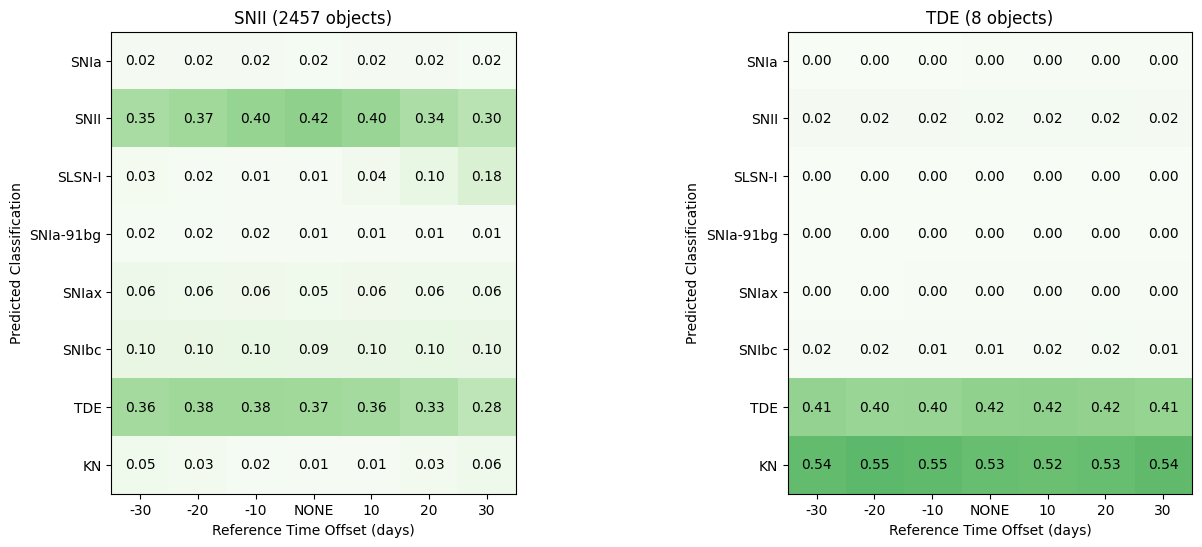

In [15]:
analysis.plot_class_grid(timing_tests, xaxis_label = "Reference Time Offset (days)", classes = "SNII,TDE", max_objects = -1)

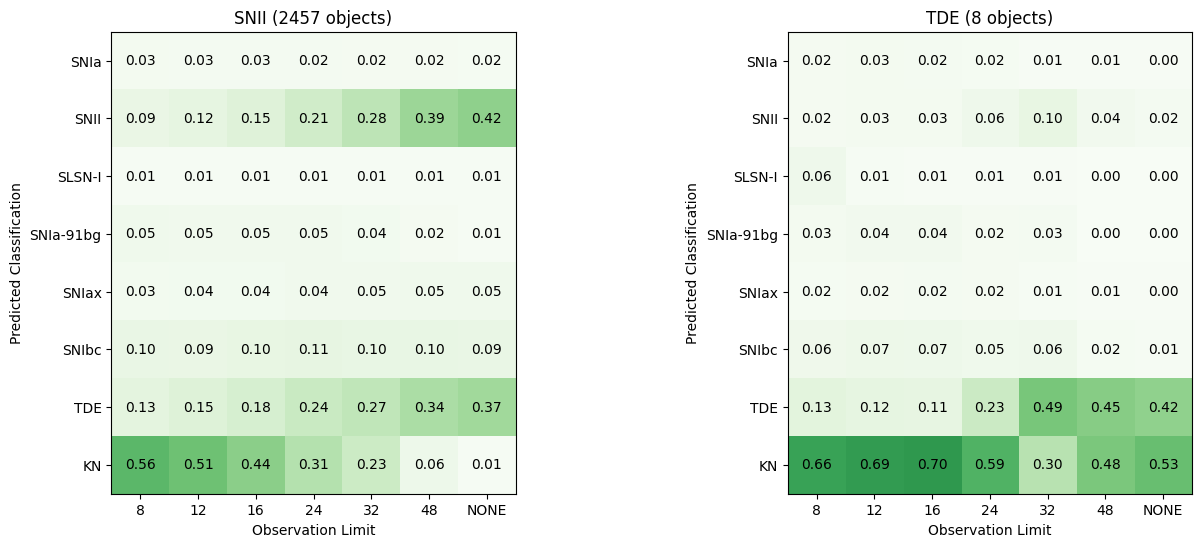

In [16]:
analysis.plot_class_grid(cutoff_tests, xaxis_label = "Observation Limit", classes = "SNII,TDE", max_objects = -1)

## All classifications when modifying reference time

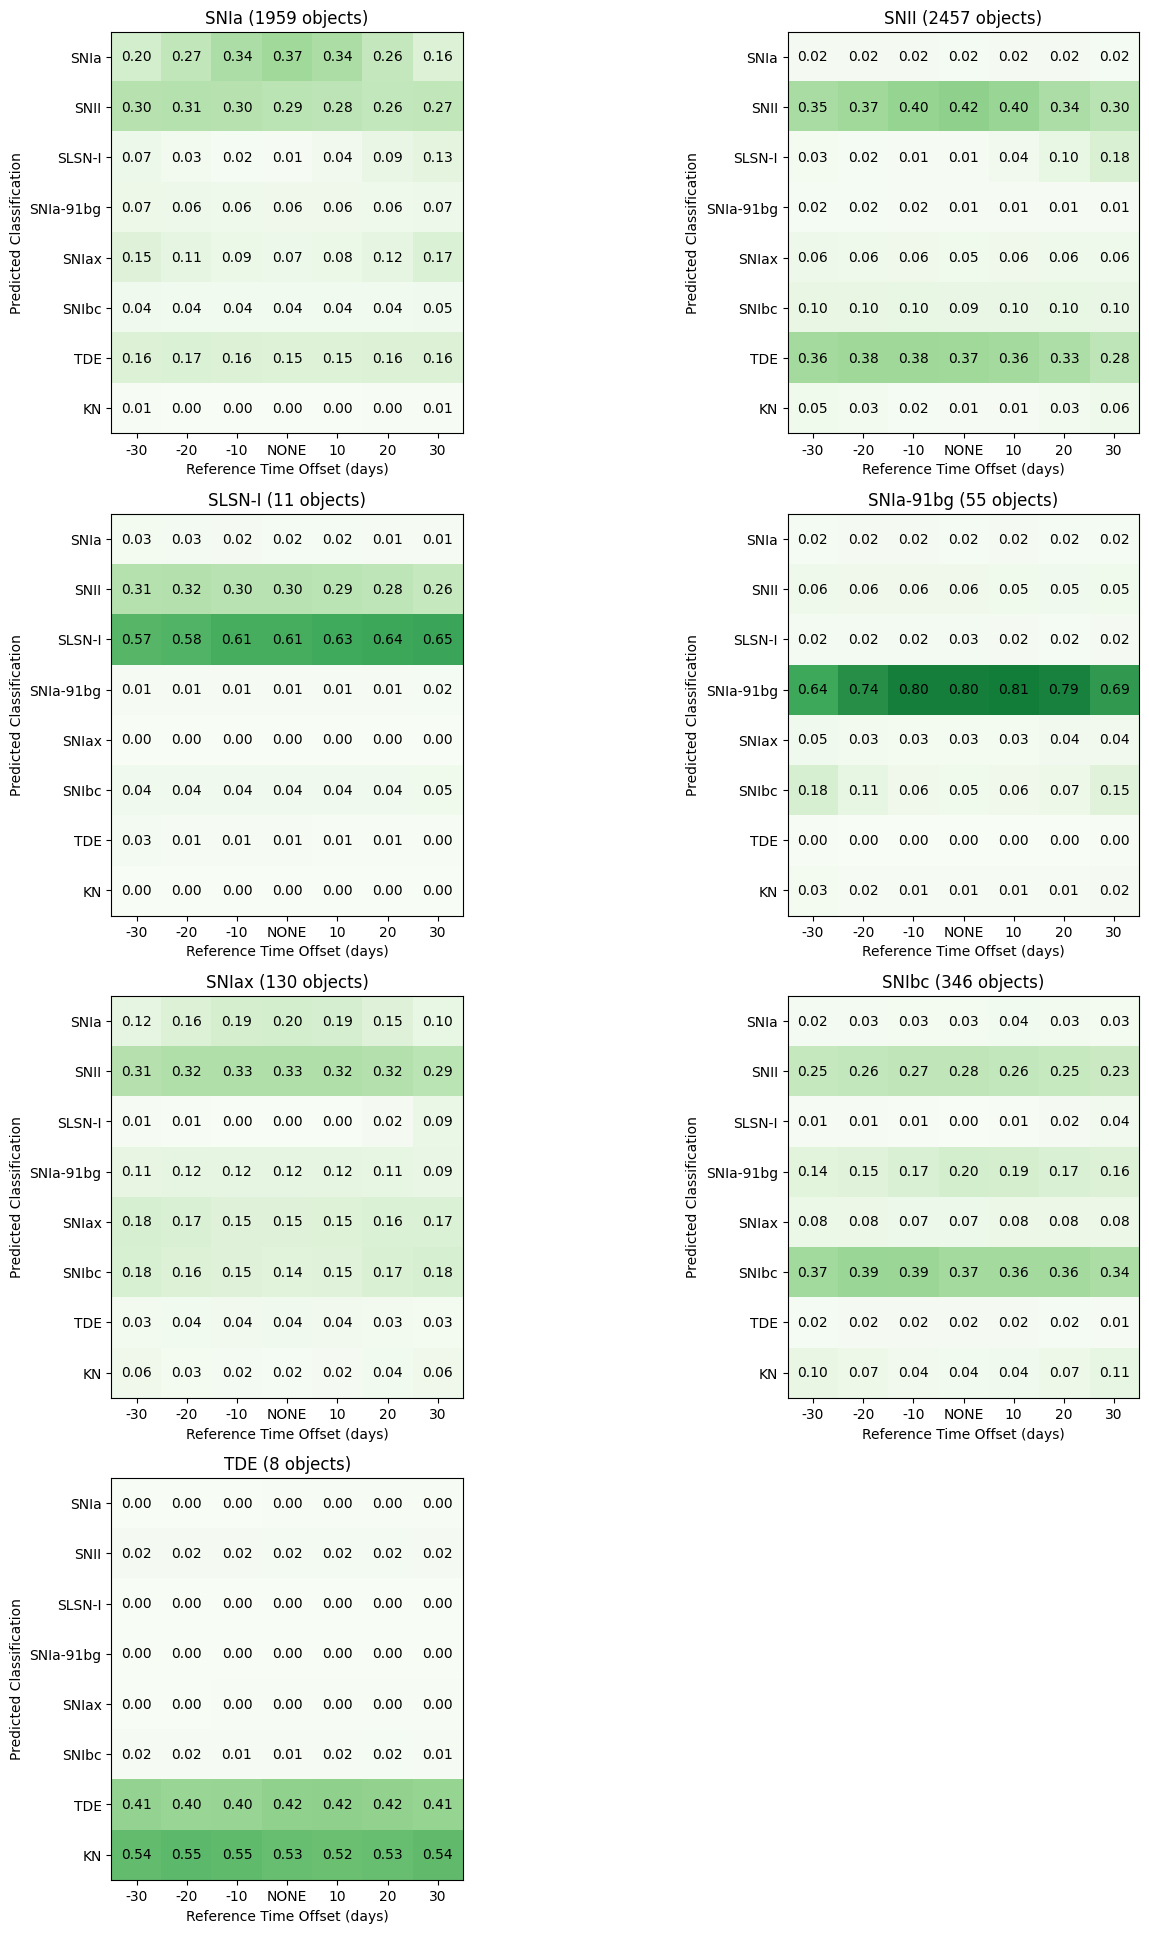

In [20]:
analysis.plot_class_grid(timing_tests, xaxis_label = "Reference Time Offset (days)", classes = "ALL", max_objects = -1)

## All classifications when modifying observation cutoff

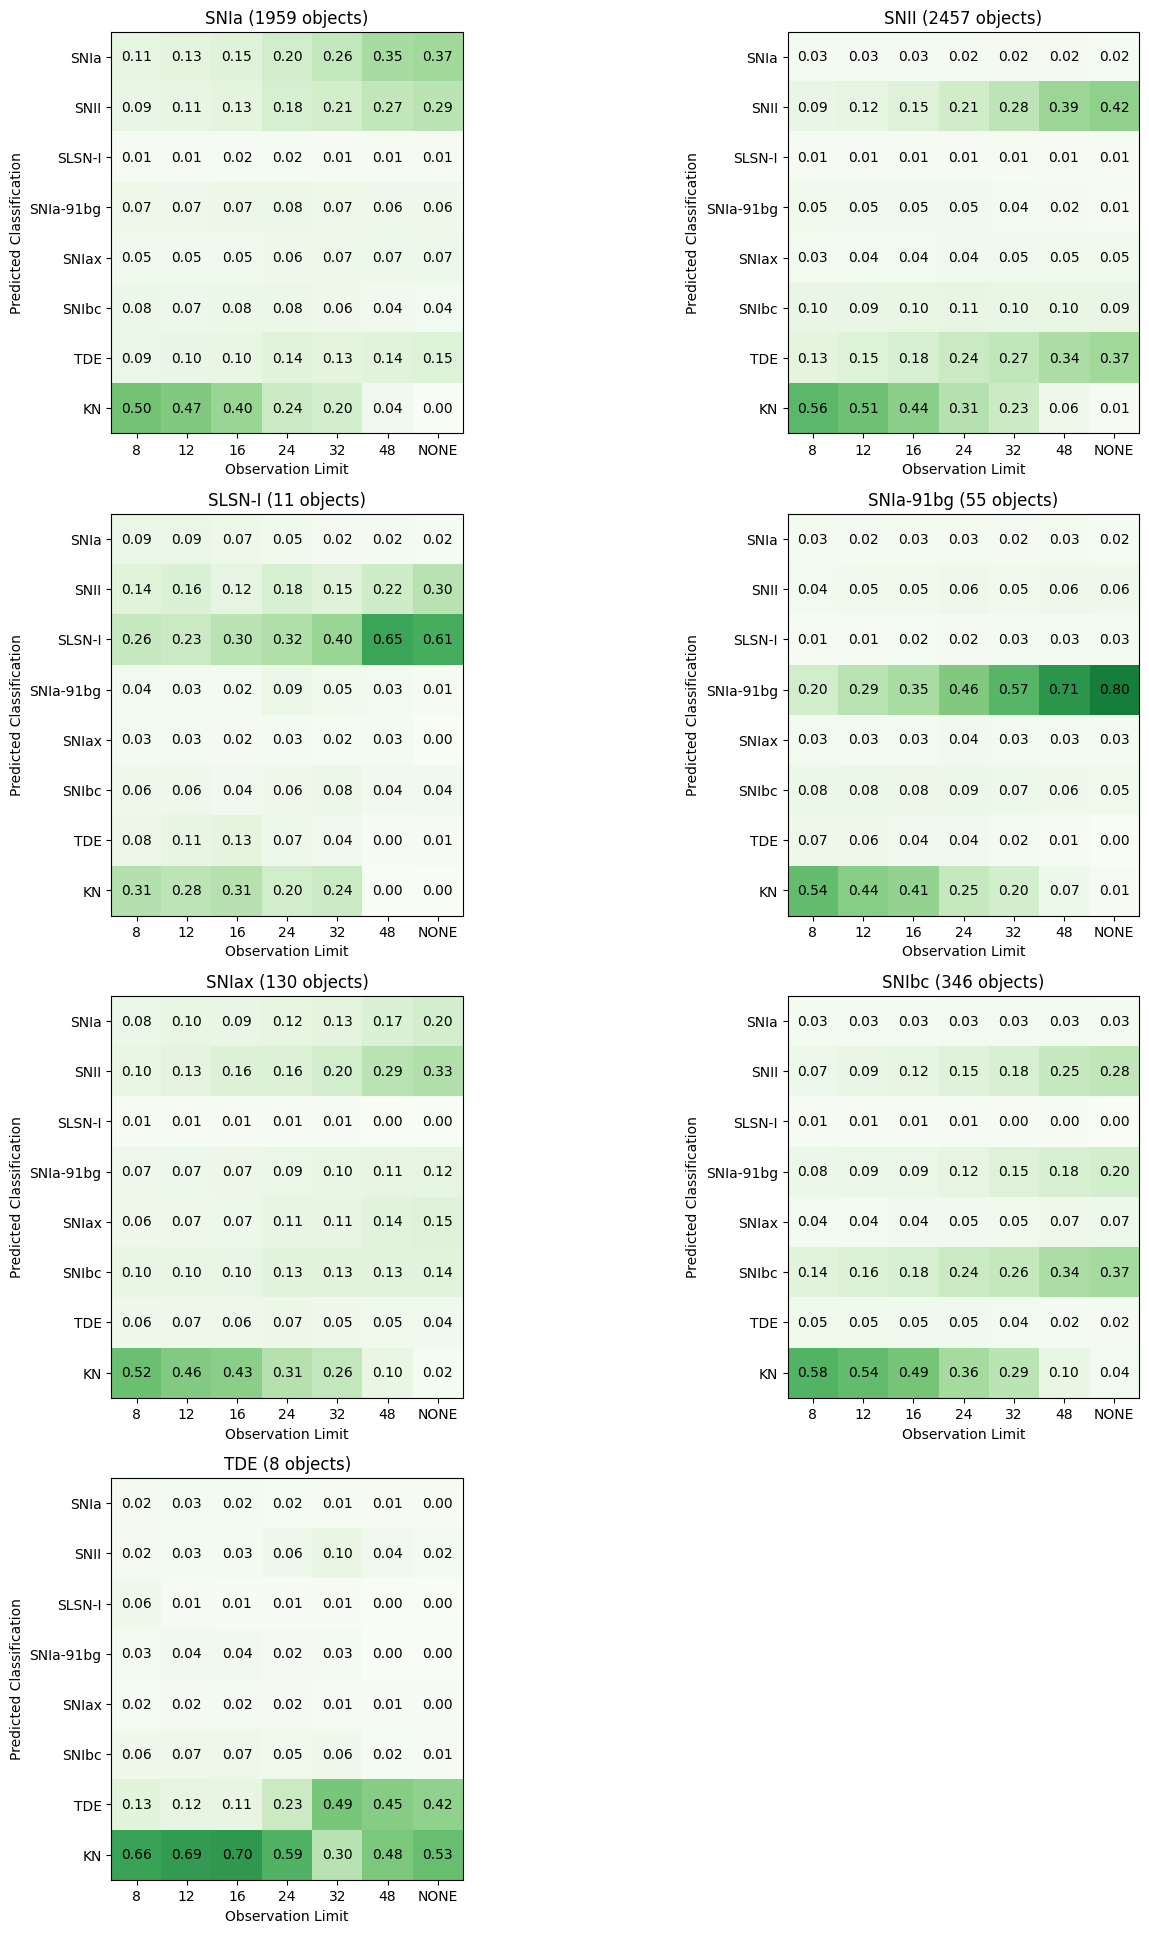

In [21]:
analysis.plot_class_grid(cutoff_tests, xaxis_label = "Observation Limit", classes = "ALL", max_objects = -1)